# Lasy Losowe

In [42]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Sprawdzenie poprawy wyników z punktów 5.8, 5.9 oraz 5.10

### Wczytywanie danych i preprocessing

In [22]:
train_data = pd.read_csv('./data/ed-titanic-training.csv')
test_data = pd.read_csv('./data/ed-titanic-test.csv')

train_data = train_data.drop(train_data.columns[0], axis=1)
test_data = test_data.drop(test_data.columns[0], axis=1)
train_data.loc[train_data['Age'] > 60, 'Age'] = 4
test_data.loc[test_data['Age'] > 60, 'Age'] = 4

x_train = train_data.drop('Survived', axis=1)
y_train = train_data['Survived']

### Znalezienie najlepszych parametrów oraz trening klasyfikatora

In [29]:
model = RandomForestClassifier()

param_grid = {
    'max_depth': np.arange(3, 20),
    'criterion': ['gini', 'entropy']
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=10)  # 10-fold cross-validation

grid_search.fit(x_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Najlepsze parametry:", best_params)
print("Najlepsza dokładność:", best_score)

Najlepsze parametry: {'criterion': 'gini', 'max_depth': 5}
Najlepsza dokładność: 0.8278606965174129


In [30]:
model = RandomForestClassifier(**best_params)
model.fit(x_train, y_train)

RandomForestClassifier(max_depth=5)

### Porównanie wpływu na dokładność klasyfikacji

In [23]:
min_samples_leaf_values = [1, 5, 10, 20, 50, 100]
max_depth_values = [1, 2, 3, 5, 10, None]

#### Pomocnicza funkcja

In [24]:
def evaluate_model(criterion):
    results = []
    for max_depth in max_depth_values:
        row = []
        for min_samples_leaf in min_samples_leaf_values:
            model = RandomForestClassifier(
                criterion=criterion, 
                max_depth=max_depth, 
                min_samples_leaf=min_samples_leaf, 
                n_jobs=-1,
                random_state=42
            )
            scores = cross_val_score(model, x_train, y_train, cv=10, scoring='accuracy')  # 10-fold cross-validation
            row.append(scores.mean())
        results.append(row)
    return pd.DataFrame(results, columns=min_samples_leaf_values, index=max_depth_values)


def plot_results(results, title, ax):
    sns.heatmap(results, annot=True, fmt=".2f", cmap='viridis', ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Min Samples Leaf')
    ax.set_ylabel('Max Depth')

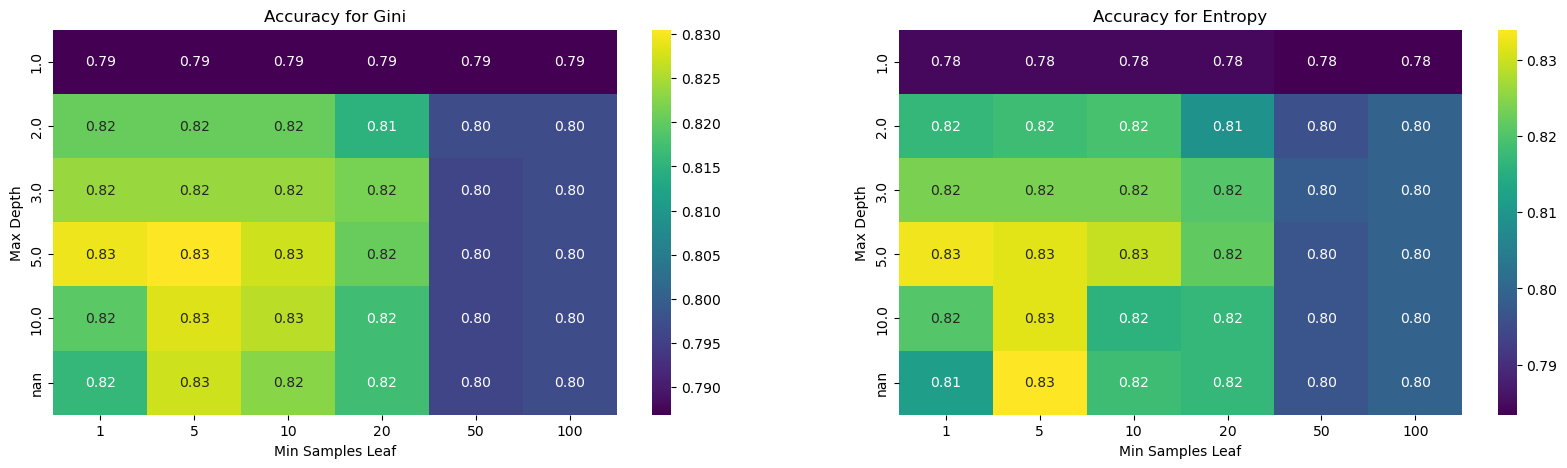

In [25]:
gini_results = evaluate_model('gini')
entropy_results = evaluate_model('entropy')

fig, axes = plt.subplots(1, 2, figsize=(20, 5))

plot_results(gini_results, "Accuracy for Gini", axes[0])
plot_results(entropy_results, "Accuracy for Entropy", axes[1])
plt.show()

#### Porównanie z 5.10

##### Zrzut ekranu dla *Drzew Decyzyjnych*

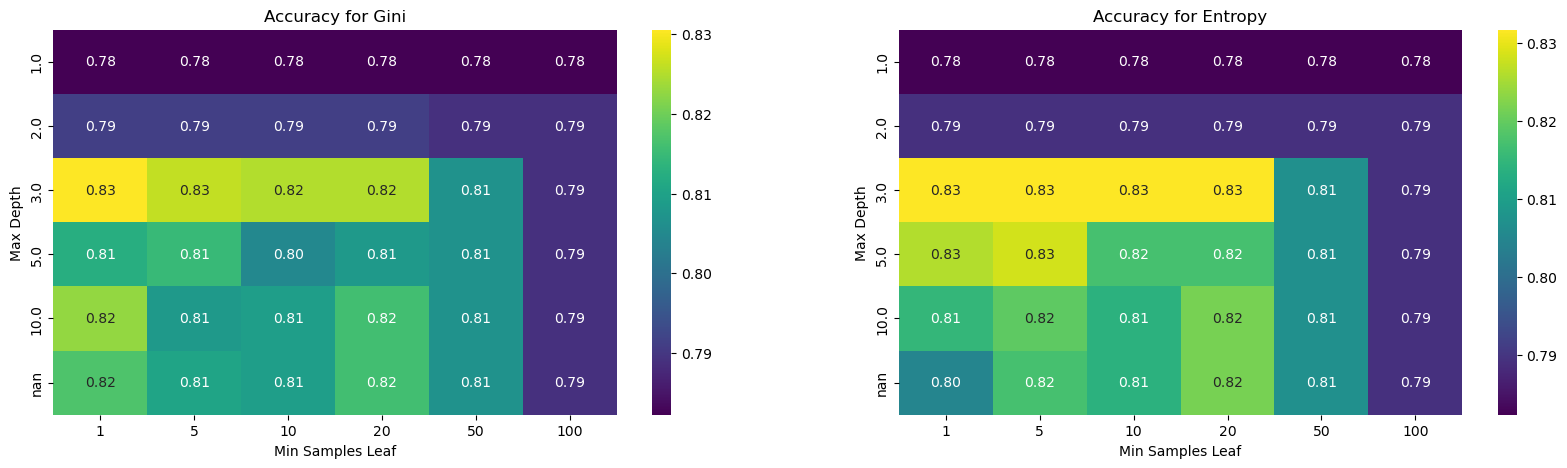

Możemy zauważyć, że maksymalne wartości `accuracy` są takie same w przypadku obu klasyfikatorów. W przypadku klasyfikatora *Random Forest*, lepsze wyniki osądamy przy większej maksymalnej głębokości drzewa niż w przypadku *Drzew Decyzyjnych*. Także zwiększanie najmniejszej liczby rekordów w liściu w przypadku klasyfikatora *Random Forest* daje lepsze efekty niż w przypadku *Drzew Decyzyjnych* (tzn. w przypadky tego klasyfikatora, potrzebna jest większa wartość, w celu uzyskania lepszych wyników).

### Podział zbioru treningowego na nowy zbiór treningowy oraz testowy

In [26]:
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.25)

### Wizualizacja macierzy rozbieżności

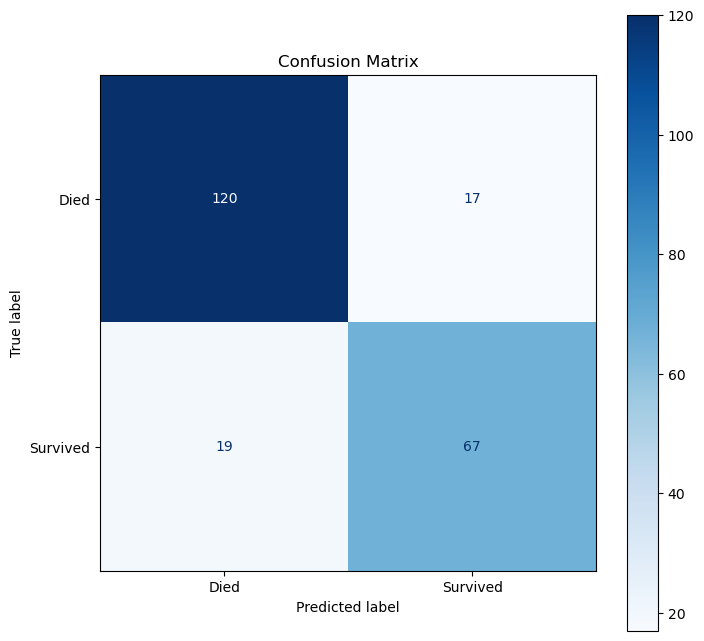

In [32]:
predictions = model.predict(x_test)
cm = confusion_matrix(y_test, predictions)

fig, ax = plt.subplots(figsize=(8, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Died', 'Survived'])
disp.plot(ax=ax, cmap='Blues')
ax.set_title('Confusion Matrix') 
plt.show()

#### Porównanie z 5.10

1. W macierzy rozbieżności z tego zadania mamy poniższe przypadki:

    - Prawdziwie negatywne (poprawnie przewidziane osoby, które zmarły): 120
    - Prawdziwie pozytywne (poprawnie przewidziane osoby, które przeżyły): 67
    - Fałszywie pozytywne (błędnie przewidziane osoby, które przeżyły): 17
    - Fałszywie negatywne (błędnie przewidziane osoby, które zmarły): 19

2. W macierzy z punktu 5.10:

    - Prawdziwie negatywne (poprawnie przewidziane osoby, które zmarły): 109
    - Prawdziwie pozytywne (poprawnie przewidziane osoby, które przeżyły): 73
    - Fałszywie pozytywne (błędnie przewidziane które przeżyły): 17
    - Fałszywie negatywne (błędnie przewidziane osoby, które zmarły): 24

Widzimy więc, że w przypadku klasyfikatora *Random Forest*, mamy zauważalnie więcej prawidłowo zaklasyfikowanych przypadków śmiertelnych oraz niewiele mniej prawidłowo zaklasyfikowanych osób, które przeżyły. Widzimy również, że mamy mniej przypadków typu *false positive* niż dla drzewa decyzyjnego.

## Testowanie dokładności klasyfikacji za pomocą klasyfikatora *RandomForest* na zbiorze *Breast Cancer*

### Wczytywanie danych i preprocessing

In [33]:
data = load_breast_cancer()
X_cancer = pd.DataFrame(data.data, columns=data.feature_names)
y_cancer = data.target

In [35]:
scaler = StandardScaler()
X_cancer_scaled = scaler.fit_transform(X_cancer)

In [37]:
pca = PCA(n_components=10)
X_cancer_pca = pca.fit_transform(X_cancer_scaled)

### Poszukiwanie najlepszych wartości parametrów

In [51]:
model = RandomForestClassifier(random_state=42)

param_grid = {
    'randomforestclassifier__n_estimators': [100, 200, 300],
    'randomforestclassifier__max_features': ['sqrt', 'log2', None],
    'randomforestclassifier__max_depth': [3, 5, 10, None],
    'randomforestclassifier__criterion': ['gini', 'entropy']
}

pipeline = Pipeline([
    ('pca', pca),
    ('randomforestclassifier', model)
])

grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=10, n_jobs=-1)

grid_search.fit(X_cancer_scaled, y_cancer)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('pca', PCA(n_components=10)),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__criterion': ['gini',
                                                               'entropy'],
                         'randomforestclassifier__max_depth': [3, 5, 10, None],
                         'randomforestclassifier__max_features': ['sqrt',
                                                                  'log2',
                                                                  None],
                         'randomforestclassifier__n_estimators': [100, 200,
                                                                  300]})

In [52]:
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Najlepsze parametry:", best_params)
print("Najlepsza dokładność:", best_score)

Najlepsze parametry: {'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__max_depth': 10, 'randomforestclassifier__max_features': None, 'randomforestclassifier__n_estimators': 300}
Najlepsza dokładność: 0.9595864661654134


In [53]:
without_pca_score = np.mean(cross_val_score(model, X_cancer_scaled, y_cancer, cv=10))
with_pca_score = np.mean(cross_val_score(grid_search.best_estimator_, X_cancer_scaled, y_cancer, cv=10))

print("Dokładność bez PCA:", without_pca_score)
print("Dokładność z PCA:", with_pca_score)

Dokładność bez PCA: 0.9631578947368421
Dokładność z PCA: 0.9595864661654134


Jak możemy zauważyć, wykorzystanie `PCA` tylko w bardzo niewielkim stopniu pogarsza dokładność klasyfikacji. Różnica jest mniejsza niż $0.4\%$.